<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales - 2023</h1>
    <h3>Clase 5</h3>
    <h5>Ejercitacion asincronica</h5>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno y Braian Drago <p>
</div>

**Modelos Ensambles**   

La propuesta del ejercicio asincronico del dia de hoy es trabajar, en base a el ejercicio 1 visto en clase y llegar a mejores resultados. Durante el transcurso del ejercicio se van a ir proponiendo varias alternativas para llegar al mejor modelo.

Tomamos los modelos base a mejorar :

1. Modelo XGBoost: con RMSE en conjunto de Test 3759.12
2. Modelo LGBM: con RMSE en conjunto de Test: 3793.18

Por lo tanto, realizamos varios pasos ya ejecutados en clase

In [ ]:
# importamos librerias / cargamos dataset / trabajamos inicialmente con el mismo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb   #
import lightgbm as lgb #
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')

URL='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/consumo_2.csv'
df = pd.read_csv(URL)
df.info()

df['Datetime'].dtype

df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')

df = df.set_index('Datetime') # Ponemos a 'Datetime' como el índice del DataFrame
df.sort_index(inplace=True) # orden cronologico
print(df.shape)
df.head()

pd.to_datetime(df.index)



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB
(145366, 1)


DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
               '2002-01-01 03:00:00', '2002-01-01 04:00:00',
               '2002-01-01 05:00:00', '2002-01-01 06:00:00',
               '2002-01-01 07:00:00', '2002-01-01 08:00:00',
               '2002-01-01 09:00:00', '2002-01-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

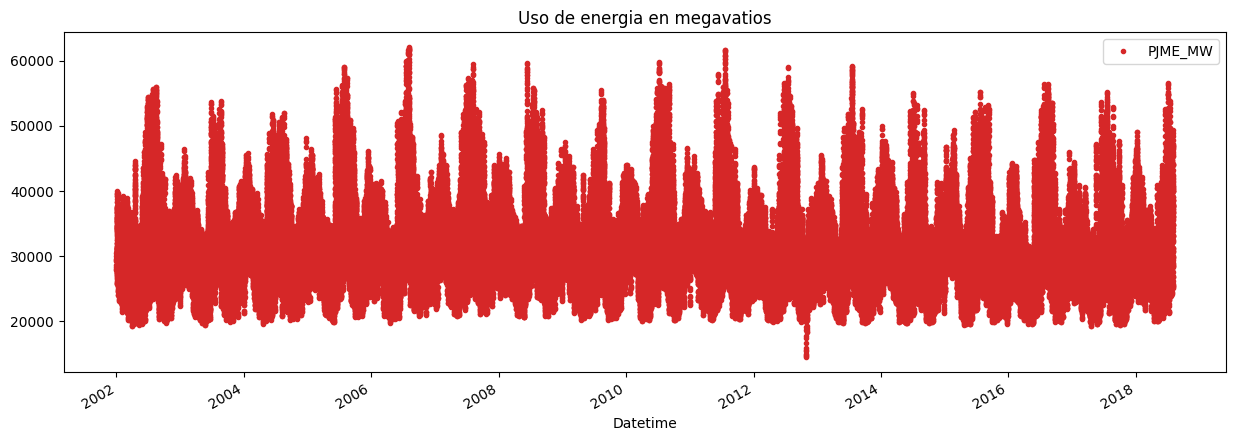

In [ ]:
# Visualizamos la serie

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[3],
        title='Uso de energia en megavatios')
plt.show()

**Comentario numero 1** <br/>  Observamos la presencia de valores atípicos en la gráfica. ¿Consideras necesario realizar alguna intervención para tratarlos?

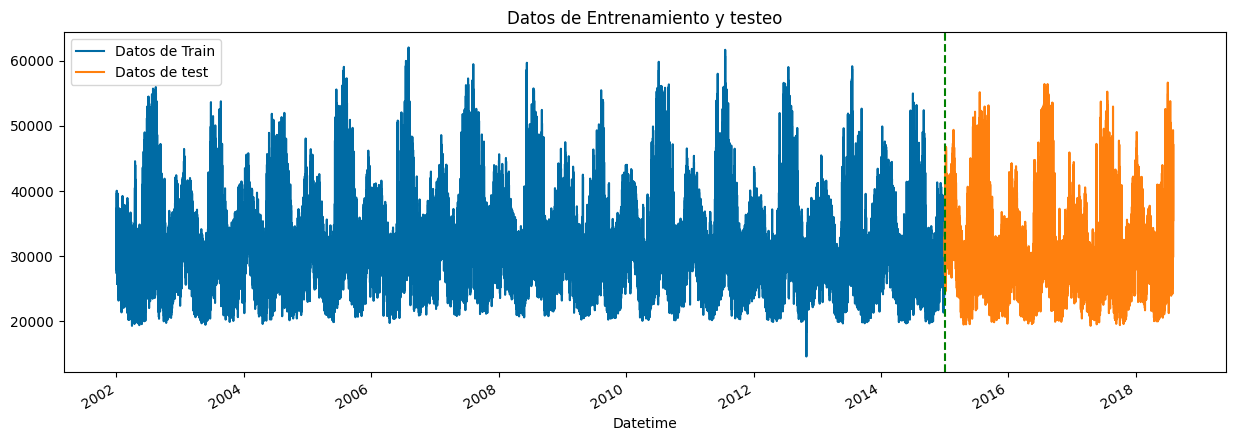

In [ ]:
# Separamos los datos en train y test

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Datos de Train', title='Datos de Entrenamiento y testeo')
test.plot(ax=ax, label='Datos de test')
ax.axvline('01-01-2015', color='green', ls='--')
ax.legend(['Datos de Train', 'Datos de test'])
plt.show()

In [ ]:
# Features  realizadas en clase

def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
df = create_features(df)
train = create_features(train)
test = create_features(test)

In [ ]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

**Comentario numero 2** <br/> Al momento, ¿ se le ocurre alguna nueva feature para sumarle al analisis

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# XGBoost (Extreme Gradient Boosting) - Modelo BASE

In [ ]:
regXGB = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
regXGB.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:5179.23300	validation_1-rmse:5359.30943
[60]	validation_0-rmse:2019.59348	validation_1-rmse:4140.66440


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

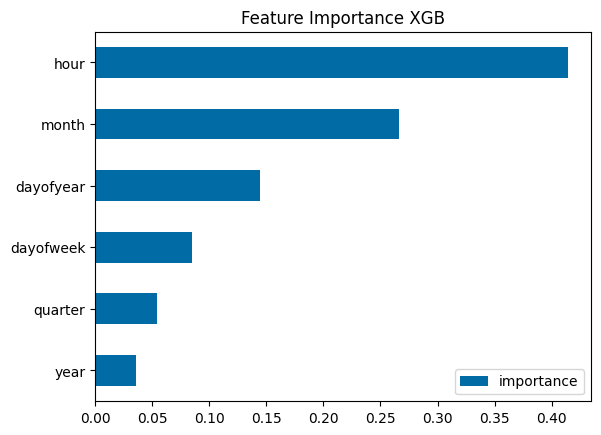

In [ ]:
fi = pd.DataFrame(data=regXGB.feature_importances_,
             index=regXGB.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance XGB')
plt.show()

**Comentario numero 3** <br/> con la informacion de la importanciad e las variables del modelo XGBoost ¿ que acciones tomaria ?

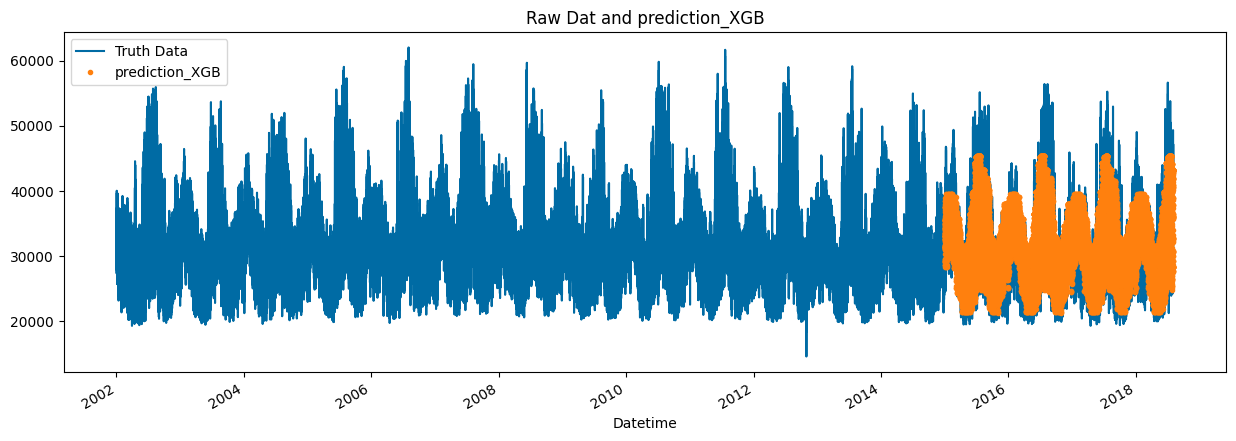

In [ ]:
test['prediction_XGB'] = regXGB.predict(X_test)
df = df.merge(test[['prediction_XGB']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction_XGB'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_XGB'])
ax.set_title('Raw Dat and prediction_XGB')
plt.show()

In [ ]:
test['prediction_XGB'] = regXGB.predict(X_test)
df = df.merge(test[['prediction_XGB']], how='left', left_index=True, right_index=True)

# Lightgbm - Modelo BASE

In [ ]:
reg_lightgbm = lgb.LGBMRegressor(n_estimators=1000, early_stopping_round=50)
reg_lightgbm.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Info] Start training from score 32289.296912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's l2: 8.25944e+06	valid_1's l2: 1.43882e+07


LGBMRegressor(early_stopping_round=50, n_estimators=1000)

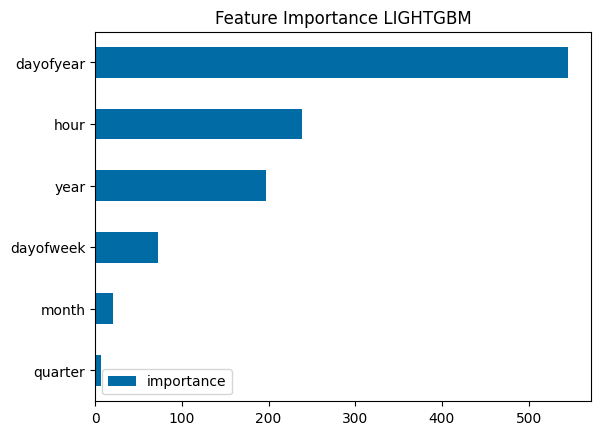

In [ ]:
fi = pd.DataFrame(data=reg_lightgbm.feature_importances_,
             index=reg_lightgbm.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance LIGHTGBM')
plt.show()

**Comentario numero 4** <br/> Vemos la importancia de las variables del modelo lightGBM, ¿ hay que realizar algun tipo de modificacion del dataset para correr nuevamente el modelo ?

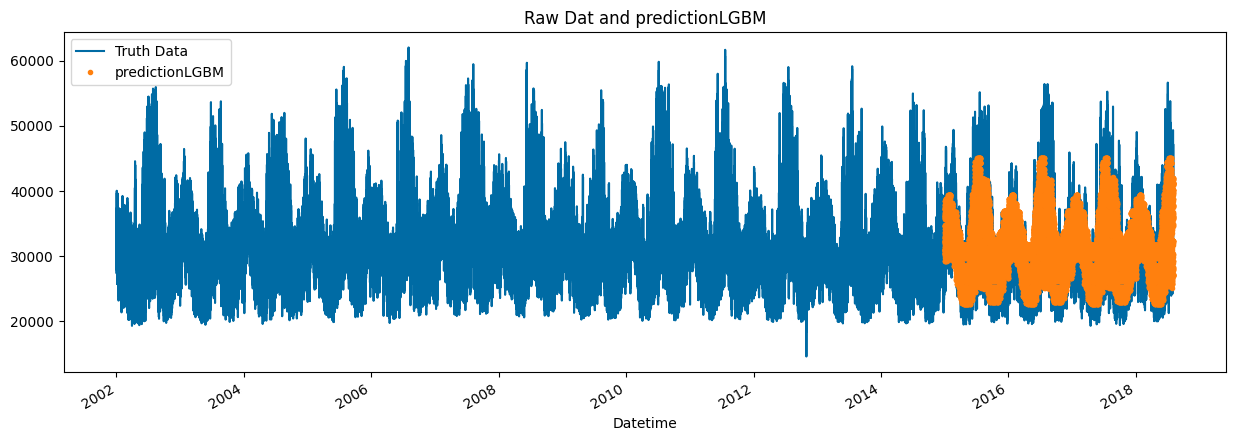

In [ ]:
test['predictionLGBM'] = reg_lightgbm.predict(X_test)
df = df.merge(test[['predictionLGBM']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['predictionLGBM'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'predictionLGBM'])
ax.set_title('Raw Dat and predictionLGBM')
plt.show()

In [ ]:
test['predictionLGBM'] = reg_lightgbm.predict(X_test)
df = df.merge(test[['predictionLGBM']], how='left', left_index=True, right_index=True)

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictionLGBM']))
print(f'RMSE en conjunto de Test Modelo LGBM: {score:0.2f}')

RMSE en conjunto de Test Modelo LGBM: 3793.18


In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction_XGB']))
print(f'RMSE en conjunto de Test. Modelo XGBoost: {score:0.2f}')

RMSE en conjunto de Test. Modelo XGBoost: 3759.12


*Tomamos estas metricas de los modelos LightGBM y XGBoost como valores base a mejorar*

**Comentario numero 5** <br/> En clase corrimos el algoritmo "optuna" para mejorar los hiperparametros . Realice algun otro tipo de trabajo para modificar los hiperparametros de ambos modelos


In [ ]:
# Agregar Lags como Features

def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df = add_lags(df)

In [ ]:
# Separamos los datos usando cross validation

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32728.69634	validation_1-rmse:32006.86635


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:51:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12533.13636	validation_1-rmse:11960.34032
[200]	validation_0-rmse:5751.00972	validation_1-rmse:5366.77615
[300]	validation_0-rmse:3876.13308	validation_1-rmse:3841.41674
[400]	validation_0-rmse:3444.25284	validation_1-rmse:3669.28162
[487]	validation_0-rmse:3333.02855	validation_1-rmse:3668.07144
[0]	validation_0-rmse:32671.86342	validation_1-rmse:32155.89701


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:52:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12514.10566	validation_1-rmse:12246.33582
[200]	validation_0-rmse:5756.43623	validation_1-rmse:5690.07179
[300]	validation_0-rmse:3906.79900	validation_1-rmse:3953.46093
[400]	validation_0-rmse:3481.58202	validation_1-rmse:3603.25338
[500]	validation_0-rmse:3357.58004	validation_1-rmse:3524.50447
[600]	validation_0-rmse:3301.70502	validation_1-rmse:3489.14496
[700]	validation_0-rmse:3262.05229	validation_1-rmse:3465.35601
[800]	validation_0-rmse:3225.04460	validation_1-rmse:3441.64780
[900]	validation_0-rmse:3198.28552	validation_1-rmse:3432.56017
[999]	validation_0-rmse:3169.14844	validation_1-rmse:3421.83469
[0]	validation_0-rmse:32634.36881	validation_1-rmse:31003.83739


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:52:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12500.74215	validation_1-rmse:11094.03695
[200]	validation_0-rmse:5752.07246	validation_1-rmse:4776.86259
[300]	validation_0-rmse:3917.70094	validation_1-rmse:3524.49482
[400]	validation_0-rmse:3495.37256	validation_1-rmse:3479.88472
[408]	validation_0-rmse:3481.22039	validation_1-rmse:3487.04605
[0]	validation_0-rmse:32526.02337	validation_1-rmse:31438.48444


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:52:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12461.42806	validation_1-rmse:12008.70597
[200]	validation_0-rmse:5737.37378	validation_1-rmse:5799.81439
[300]	validation_0-rmse:3916.50594	validation_1-rmse:4391.07552
[400]	validation_0-rmse:3498.80019	validation_1-rmse:4176.47678
[500]	validation_0-rmse:3383.25907	validation_1-rmse:4118.91932
[600]	validation_0-rmse:3324.32132	validation_1-rmse:4108.38582
[700]	validation_0-rmse:3281.79000	validation_1-rmse:4091.09930
[800]	validation_0-rmse:3249.30039	validation_1-rmse:4083.92723
[900]	validation_0-rmse:3222.83815	validation_1-rmse:4080.86294
[999]	validation_0-rmse:3199.28299	validation_1-rmse:4066.01906
[0]	validation_0-rmse:32457.31197	validation_1-rmse:31417.91480


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:52:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12444.15715	validation_1-rmse:11934.58482
[200]	validation_0-rmse:5751.53604	validation_1-rmse:5599.28951
[300]	validation_0-rmse:3950.99108	validation_1-rmse:4146.82377
[400]	validation_0-rmse:3542.70123	validation_1-rmse:3999.80441
[460]	validation_0-rmse:3462.41564	validation_1-rmse:4007.77460


# Consigna final : En base a todo lo comentado. Realice los diferentes modelos para llegar al resultado optimo. ¿ hay alguna otra alternativa para mejorar el modelo ? ¿ cual podria ser?

In [ ]:
# A partir de aqui realizar las tareas para llegar a los mejores modelos






FIN DEL EJERCICIO ASINCRONICO - CLASE 5 - GRACIAS